<a href="https://colab.research.google.com/github/ray-hu/Image-Segmentation/blob/master/SVM_RF_EM_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-peparation 

### Import Libraries

In [1]:
# install
!pip install mahotas
!pip install progressbar2

    100% |████████████████████████████████| 1.5MB 16.5MB/s 
  Running setup.py bdist_wheel for mahotas ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/fb/2a/81/12bc1070527dc81ef856f9d36db9ec0a42e8c14985d005395b
Successfully built mahotas


In [0]:
import cv2
import numpy as np
import pylab as plt
from glob import glob
import argparse
import os
import progressbar
import pickle as pkl
from numpy.lib import stride_tricks
from skimage import feature
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time
import mahotas as mt

### Mounting Google Drive locally

In [3]:
from google.colab import drive
drive.mount('./GoogleDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./GoogleDrive


In [0]:
! ln -s GoogleDrive/My\ Drive ./drive

In [5]:
! ls

drive  GoogleDrive  sample_data


# Extract Features from the images

**Feature Vector:**

1. 

2.   **Texture**


*   Local binary pattern(LBP)



3.  ** Haralick's texture features**


*  Angular second moment
* Contrast
* Correlation
* Sum of Square: variance
* Inverse difference moment
* Sum average
* Sum variance
* Sum entropy
* Entropy


---

### Load dataset

In [0]:
import numpy as np
import skimage
from skimage import io
import glob
import cv2
import matplotlib.pyplot as plt

def load_data_set(load_aug = False):
  import skimage
  imgs = io.imread('drive/EM/train-volume.tif')
  imgs = skimage.color.gray2rgb(imgs)
  labels = io.imread('drive/EM/train-labels.tif')
  test = io.imread('drive/EM/test-volume.tif')
  test = skimage.color.gray2rgb(test)
  imgs_train = []
  label_train = []
  imgs_test = []

  print("_"*30)
  print("[INFO] Loading orginal training data...")
  for i in range(len(imgs)):
    imgs_train.append(np.array(imgs[i]))
    label_train.append(np.array(labels[i]))
  print("check the consistency of training data...")
  print("num of imgs_train: {}".format(len(imgs_train)))
  print('num of groundTruth_train: {}'.format(len(label_train)))
  
  print("_"*30)
  print("[INFO] Loading orginal testing data...")
  for i in range(len(test)):
    imgs_test.append(np.array(test[i]))
  print('num of test images: {}'.format(len(imgs_test)))
  return imgs_train, label_train, imgs_test


In [7]:
imgs_train, label_train, imgs_test = load_data_set()

______________________________
[INFO] Loading orginal training data...
check the consistency of training data...
num of imgs_train: 30
num of groundTruth_train: 30
______________________________
[INFO] Loading orginal testing data...
num of test images: 30


Showing the orginal data:


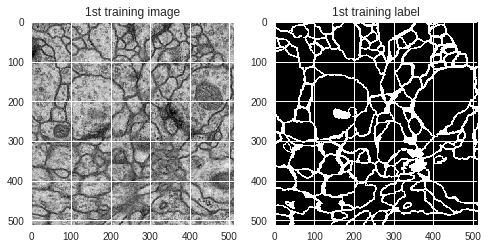

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(1,2)
ax[0].imshow(imgs_train[0])
ax[0].set_title('1st training image')
ax[1].imshow(label_train[0])
ax[1].set_title('1st training label')
plt.show()

### Extract Features

In [0]:
from skimage import feature
from numpy.lib import stride_tricks
import mahotas as mt
import progressbar

def extract_features(img, img_gary, label, train, lbp_radius = 10, lbp_points_ratio = 4, h_neighbors = 11, num_examples = 1000):
  '''
  extract above 13 features
  '''
  #1.  RGB values have beed extracted when loading the orignal dataset
  
  #2.  Local Binary Pattern
  def LBP(img,points,radius):
    '''
     points: Number of circularly symmetric neighbour set points 
     radius: Radius of circle
    '''
    #print(' extracting local binary pattern features.')
    lbp = feature.local_binary_pattern(img, points, radius)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255
  
  #3. Haralick's texture features
  def HTF(img, h_neighbors, ss_dix):
    '''
    h_neighbors:
    '''
    #print(' extracting haralick texture features.')
    size = h_neighbors
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    # should be equal to the size of feature_img = feature_img[h_index:-h_index, h_index:-h_index]
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides = strides)
    patches = patches.reshape(-1,size,size)
    
    if len(ss_idx) == 0:
      bar = progressbar.ProgressBar(maxval = len(patches), \
                                   widgets = [progressbar.Bar('=','[', ']'), ' ', progressbar.Percentage()])
    else:
      bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    
    def calculate_haralick(img):
      '''
      calculate haralick features for each patch
      '''
      features = []
      
      feature_ = mt.features.haralick(img)
      mean_ = feature_.mean(axis=0)
      
      [features.append(i) for i in mean_[0:9]]
      
      return np.array(features)
    
   
    bar.start()
    h_features = []
    
    if len(ss_idx) == 0:
      for i, p in enumerate(patches):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    else:
      for i, p in enumerate(patches[ss_idx]):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    
    return np.array(h_features)
  
  
  #4. extracting all the features
  
  # Hyperparameters:
  #lbp_radius = 10 # local binary pattern neighbourhood
  lbp_points = lbp_radius*lbp_points_ratio # number of circularly symmetric neighbour set points 
  #h_neighbors = 11 # haralick neighbourhood
  
  
  #num_examples = 1000 # number of examples (pixels) per image to use for training model
  h_index = int((h_neighbors -1)/2)
  
  feature_img = np.zeros((img.shape[0], img.shape[1],4))
  feature_img[:,:,:3] = img
  feature_img[:,:,3] = LBP(img_gary, lbp_points, lbp_radius)
  feature_img = feature_img[h_index:-h_index, h_index:-h_index]
  s = feature_img.shape
  features = feature_img.reshape((s[0]*s[1], s[2]))
  
  if train:
    ss_idx = np.random.randint(0,features.shape[0],num_examples)
    features = features[ss_idx]
  else:
    ss_idx = []
  
  h_features = HTF(img_gary, h_neighbors, ss_idx)
  features = np.hstack((features, h_features))
  
  if train:
    label = label[h_index:-h_index, h_index:-h_index]
    labels = label.reshape(label.shape[0]*label.shape[1],1)
    labels = labels[ss_idx]
  else:
    labels = None
 
  return features, labels

### Generate new training dataset

In [0]:
def generate_training_data(imgs_train, label_train, train,
                           lbp_radius = 10, lbp_points_ratio = 4,
                           h_neighbors = 11, num_examples = 1000):
  print("_"*30)
  print("[INFO] Extracting features from original image(s)")
  
  Features = []
  Labels = []
  
  for i, img in enumerate(imgs_train):
    img_gary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, labels = extract_features(img,img_gary,label_train[i], train = train,
                                        lbp_radius = 10, lbp_points_ratio = 4,
                                        h_neighbors = 11, num_examples = 1000)
    Features.append(features)
    Labels.append(labels)
    
  Features = np.array(Features)
  s = Features.shape
  Features = Features.reshape((s[0]*s[1],s[2]))
  Labels = np.array(Labels)
  s = Labels.shape
  Labels = Labels.reshape((s[0]*s[1],s[2]))
  Labels = Labels.ravel()
  Labels[Labels==255] =1
  
  print("_"*30)
  print("[INFO] check the size of generated training data")
  print('size of the feature vector: {}'.format(Features.shape))
  print('size of the label vertor: {}'.format(Labels.shape))
  
  np.save('drive/data/X.npy',Features)
  np.save('drive/data/Y.npy', Labels)
  
  return Features, Labels
  

In [0]:
X, Y = generate_training_data(imgs_train, label_train, train=True)

______________________________
[INFO] Extracting features from original image(s)


[========================================================================] 100%

______________________________
[INFO] check the size of generated training data
size of the feature vector: (30000, 13)
size of the label vertor: (30000,)


In [0]:
import numpy as np 
X = np.load('drive/data/X.npy')
Y = np.load('drive/data/Y.npy')

# Training

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time

def train(train_X, train_Y, classifier):
  
  start_time = time.time()
  
  if classifier == "SVM":
    print("_"*30)
    print ('[INFO] Training a Support Vector Machine model.')
    model = SVC(kernel = 'linear')
  elif classifier == "RF":
    print("_"*30)
    print('[INFO] Training a Random Forest model.')
    model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
  elif classifier == "GBC":
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    
  model.fit(train_X, train_Y)
  
  
  end_time = time.time()
  filename = 'drive/data/'+ classifier + '_model.pkl'
  with open(filename, 'wb') as file:  
    pickle.dump(model, file)
  
  print("_"*30)
  print('[INFO] Training complete.')
  print('training time: %.4f s' %(end_time-start_time))
  
  return model

In [0]:
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.2, random_state=42) 

In [45]:

model = train(train_X, train_Y, classifier='SVM')

______________________________
[INFO] Training a Support Vector Machine model.
______________________________
[INFO] Training complete.
training time: 1176.0616 s


# Testing

In [0]:
def test(test_X, test_Y, classifier):
  
  # load trained model
  pkl_filename = filename = 'drive/data/'+ classifier + '_model.pkl'
  with open(pkl_filename, 'rb') as file:  
    model = pickle.load(file)
  
  # predict
  pred = model.predict(test_X)
  precision = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
  recall = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
  f1 = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
  accuracy = metrics.accuracy_score(test_Y, pred)
  print ('_'*30)
  print('[RESULTS] Testing...')
  print ('Accuracy: %.4f' %accuracy)
  print ('Precision: %.4f' %precision)
  print ('Recall: %.4f' %recall)
  print ('F1: %.4f' %f1)
 

In [47]:
test(train_X, train_Y,classifier = 'SVM')

______________________________
[RESULTS] Testing...
Accuracy: 0.8295
Precision: 0.8685
Recall: 0.9198
F1: 0.8934


In [48]:
test(test_X, test_Y, classifier = 'SVM')

______________________________
[RESULTS] Testing...
Accuracy: 0.8283
Precision: 0.8684
Recall: 0.9189
F1: 0.8929


# Tuning Hyperparameters

#### Hyperparameter for SVM
1. C: regularization patameter
2. kernel: 'linear', 'poly', 'rbf', sigmoid, ...
3. degree: degree of 'poly' kernel
4. gamma: kernel coefficient for 'rbf', 'poly' and 'sigmoid'

#### Hyperparameter for RandomForest
1. n_estimators: num of trees in the forest
2. criterion: function to measure the quality of a split, 'gini' or 'entropy'
3. max_depth: max depth of the tree
4. min_samples_split: min num of samples to split an internal node
5. min_samples_leaf: min num of samples to be at a leaf node
6. max_features: num of features to consider when looking for the best split
7. bootstrap: method for sampling data points(with or without replacement)

#### Hyperparameter for feature extraction
1. lbp_radius: local binary pattern neighborhood
2. h_neighbors: haralick neighborhood
3. num_examples: num of examples per image to use for training

#### Other parameters related to above
1. lbp_points = lbp_radius*8
2. h_index = int((h_neighbors -1)/2)

## Tuning hyperparameters for RandomForest
Random Forest
* 	n_estimators: num of trees in the forest;
* 	criterion: function to measure the quality of a split, 'gini' or 'entropy';
* 	max_depth: max depth of the tree;
* 	min_samples_split: min num of samples to split an internal node;
* 	min_samples_leaf: min num of samples to be at a leaf node;
* 	max_features: num of features to consider when looking for the best split;
* 	bootstrap: method for sampling data points(with or without replacement).


In [0]:
import numpy as np
import pprint
from sklearn.model_selection import RandomizedSearchCV

def train_tune_para_RF(train_X, train_Y):
  
  print("_"*30)
  print('[INFO] Tuning hyperparameters for randomforest model.')
  
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
  # Criterion
  criterion = ['gini','entropy']
  # Number of features to consider at every split
  max_features = ['auto','sqrt']
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
  max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [int(x) for x in np.linspace(2, 20, num = 19)]
  # Method of selecting samples for training each tree
  bootstrap = [True, False]
  # Create the random grid
  
  random_grid = {'n_estimators': n_estimators,
                 'criterion':criterion,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap}
  pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(random_grid)
  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  rf = RandomForestClassifier()
  # Random search of parameters, using 3 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  # Fit the random search model
  rf_search.fit(train_X, train_Y)
  
  filename = 'drive/data/RF_search_model.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(rf_search, file)
    
  pkl_filename = 'drive/data/RF_search_model.pkl' 
  with open(pkl_filename, 'rb') as file:
    rf_search_model = pickle.load(file)

  print("_"*30)
  print("[RESULTS] After tuning")
  print('best hyperparameters:')
  #pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(rf_search_model.best_params_)
  # use these model to train the model again or :
  #best_model = rf_search_model.best_estimator_
  #best_accuracy = evaluate(best_model, test_X, test_Y)
  #print('accuracy = {}'.format(best_accuracy))
  
  return rf_search

In [0]:
tf_search = train_tune_para_RF(train_X, train_Y)

In [0]:
pkl_filename = 'drive/data/RF_search_model.pkl' 
with open(pkl_filename, 'rb') as file:
  rf_search_model = pickle.load(file)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(rf_search_model.best_params_)

best_model = rf_search_model.best_estimator_
pred = best_model.predict(test_X)
precision = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
recall = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
f1 = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
accuracy = metrics.accuracy_score(test_Y, pred)
print ('_'*30)
print('[RESULTS] Testing...')
print ('Accuracy: %.2f' %accuracy)
print ('Precision: %.2f' %precision)
print ('Recall: %.2f' %recall)
print ('F1: %.2f' %f1)

In [0]:
def show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'n_estimators'):
  
  print("_"*30)
  print('[INFO] Showing hyperparameters impact for randomforest model.')
  
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
  # Criterion
  criterion = ['gini','entropy']
  # Number of features to consider at every split
  max_features = ['auto','sqrt']
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
  max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [int(x) for x in np.linspace(2, 200, num = 19)]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [int(x) for x in np.linspace(2, 20, num = 19)]
  # Method of selecting samples for training each tree
  bootstrap = [True, False]
  # Create the random grid
  if para == 'n_estimators':
    n = len(n_estimators)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(n_estimators)):
      model = RandomForestClassifier(n_estimators=n_estimators[i], criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = n_estimators
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([1,20,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
      
  elif para == 'criterion':
    n = len(criterion)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(criterion)):
      model = RandomForestClassifier(n_estimators=15, criterion = criterion[i], max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    print('when criterion = ', criterion)
    print('train_score: ', train_score)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F1 score: ', f1)
    return train_score, accuracy, precision, recall, f1
  
  elif para == 'max_features':
    n = len(max_features)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(max_features)):
      model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features =max_features[i],
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    print('when max_features = ', criterion)
    print('train_score: ', train_score)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F1 score: ', f1)
    return train_score, accuracy, precision, recall, f1
  
  elif para == 'max_depth':
    n = len(max_depth)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(max_depth)):
      model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',                   
                                     max_depth=max_depth[i], min_samples_split = 3, min_samples_leaf = 18,
                                     random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
      
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = max_depth
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([1,20,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
  
  elif para == 'min_samples_split':
    n = len(min_samples_split)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(min_samples_split)):
      model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = min_samples_split[i], min_samples_leaf = 18,
                                     random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = min_samples_split
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([2,200,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
      
  elif para == 'min_samples_leaf':
    n = len(min_samples_leaf)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(min_samples_leaf)):
      model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = min_samples_leaf[i],
                                     random_state=42, bootstrap = 'True')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = min_samples_leaf
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([2,20,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
    
    
  elif para == 'bootstrap':
    n = len(bootstrap)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(bootstrap)):
      model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18,
                                     random_state=42, bootstrap = bootstrap[i])
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='weighted', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='weighted', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='weighted', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    print('when bootstrap = ', bootstrap)
    print('train_score: ', train_score)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F1 score: ', f1)
    return train_score, accuracy, precision, recall, f1
  
  

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...


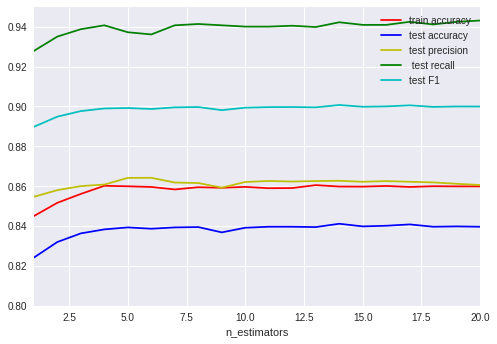

In [0]:

train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'n_estimators')

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'criterion')

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...
when criterion =  ['gini', 'entropy']
train_score:  [0.86116667 0.85979167]
accuracy:  [0.8385     0.83983333]
precision:  [0.86041418 0.86222045]
recall:  [0.94159948 0.94094574]
F1 score:  [0.89917803 0.89986454]


In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'max_features')

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...
when max_features =  ['gini', 'entropy']
train_score:  [0.85979167 0.85979167]
accuracy:  [0.83983333 0.83983333]
precision:  [0.86222045 0.86222045]
recall:  [0.94094574 0.94094574]
F1 score:  [0.89986454 0.89986454]


______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...


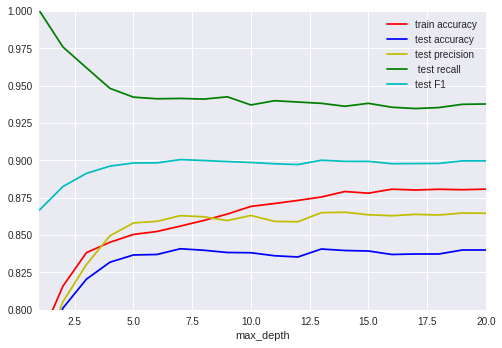

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'max_depth')

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...


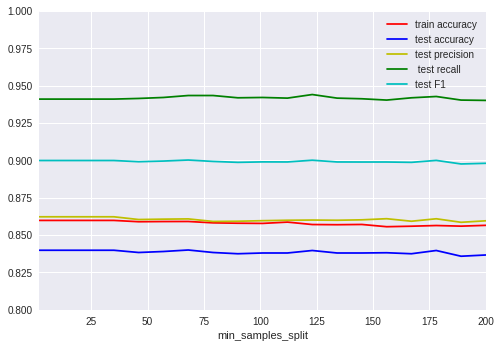

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'min_samples_split')

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...


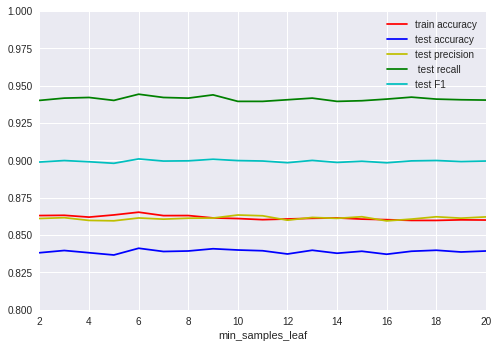

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'min_samples_leaf')

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_RF(train_X, train_Y, test_X, test_Y, para = 'bootstrap')

______________________________
[INFO] Showing hyperparameters impact for randomforest model.
______________________________
[RESULTS] Ploting the results...
when bootstrap =  [True, False]
train_score:  [0.85979167 0.86125   ]
accuracy:  [0.83983333 0.83483333]
precision:  [0.83037749 0.82444662]
recall:  [0.83983333 0.83483333]
F1 score:  [0.82936597 0.8226581 ]


## Tuning hyperparameters for SVM

SVM
* 	C: regularization patameter;
* 	kernel: 'linear', 'poly', 'rbf', sigmoid, ...;
* 	degree: degree of 'poly' kernel;
* 	gamma: kernel coefficient for 'rbf', 'poly' and 'sigmoid';




In [0]:
def show_tune_para_SVM(train_X, train_Y, test_X, test_Y, para = 'n_estimators'):
  
  print("_"*30)
  print('[INFO] Showing hyperparameters impact for svm model.')
  
  # C: regularization patameter
  
  C = np.linspace(0.1,1,num=10)
  # kernel: 'linear', 'poly', 'rbf', sigmoid, ...
  kernel = ['linear', 'poly', 'rbf', 'sigmoid']
  # degree: degree of 'poly' kernel
  degree = [3,4,5,6,7,8,9,10]
  # gamma: kernel coefficient for 'rbf', 'poly' and 'sigmoid'
  gamma = ['auto', 'scale']

  if para == 'C':
    n = len(C)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(C)):
      model = SVC(C[i], kernel = 'linear')
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = C
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([0,1,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
      
  elif para == 'kernel':
    n = len(kernel)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(kernel)):
      model = SVC(kernel = kernel[i])
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    print('when kernel= ', kernel)
    print('train_score: ', train_score)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F1 score: ', f1)
    return train_score, accuracy, precision, recall, f1
  
  elif para == 'degree':
    n = len(degree)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(degree)):
      model = SVC(kernel = 'poly', degree=degree[i])
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    x = degree
    plt.figure()
    plt.plot(x, train_score, 'r')
    plt.plot(x, accuracy, 'b')
    plt.plot(x, precision, 'y')
    plt.plot(x, recall, 'g')
    plt.plot(x, f1, 'c')
    plt.xlabel(para)
    plt.axis([2,200,0.8,1])
    plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
    plt.show()
    return train_score, accuracy, precision, recall, f1
  
  elif para == 'gamma':
    n = len(gamma)
    train_score = np.zeros(n); accuracy = np.zeros(n);
    precision = np.zeros(n); recall = np.zeros(n); f1 = np.zeros(n)
    for i in range(len(max_depth)):
      model = SVC(kernel = 'poly', gamma = gamma[i])
      model.fit(train_X, train_Y)
      pred_train = model.predict(train_X)
      train_score[i] = metrics.accuracy_score(train_Y, pred_train)
      pred = model.predict(test_X)
      precision[i] = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
      recall[i] = metrics.recall_score(test_Y, pred, average='binary', labels=np.unique(pred))
      f1[i] = metrics.f1_score(test_Y, pred, average='binary', labels=np.unique(pred))
      accuracy[i] = metrics.accuracy_score(test_Y, pred)
      
    print("_"*30)
    print("[RESULTS] Ploting the results...")
    print('when gamma = ', gamma)
    print('train_score: ', train_score)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F1 score: ', f1)
    return train_score, accuracy, precision, recall, f1
 

______________________________
[INFO] Showing hyperparameters impact for svm model.
______________________________
[RESULTS] Ploting the results...


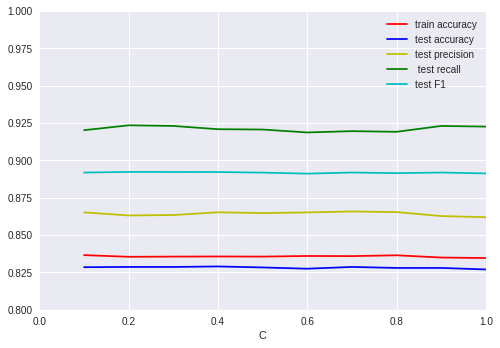

In [0]:
train_score, accuracy, precision, recall, f1 = show_tune_para_SVM(train_X, train_Y, test_X, test_Y, para = 'C')

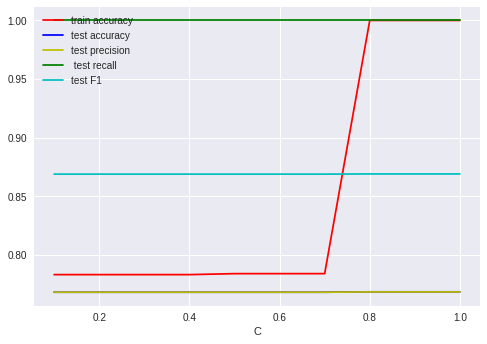

In [0]:
x = np.linspace(0.1,1,num=10)
plt.figure()
plt.plot(x, train_score, 'r')
plt.plot(x, accuracy, 'b')
plt.plot(x, precision, 'y')
plt.plot(x, recall, 'g')
plt.plot(x, f1, 'c')
plt.xlabel('C')
#plt.axis([0,1,0.8,1])
plt.legend(['train accuracy', 'test accuracy', 'test precision', ' test recall','test F1'])
plt.show()

In [0]:
import numpy as np
import pprint
from sklearn.model_selection import RandomizedSearchCV

def train_tune_para_SVM(train_X, train_Y):
  
  print("_"*30)
  print('[INFO] Tuning hyperparameters for SVM model.')
  
  # C: regularization patameter
  
  C = np.linspace(0.1,1,num=10)
  # kernel: 'linear', 'poly', 'rbf', sigmoid, ...
  kernel = ['linear', 'poly', 'rbf', 'sigmoid']
  # degree: degree of 'poly' kernel
  degree = [3,4,5,6,7,8,9,10]
  # gamma: kernel coefficient for 'rbf', 'poly' and 'sigmoid'
  
  # Create the random grid
  random_grid = {'C': C,
                 'kernel': kernel,
                 'degree': degree}
  pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(random_grid)
  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  estimator = SVC()
  # Random search of parameters, using 5 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  svc_search = RandomizedSearchCV(estimator = estimator, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  # Fit the random search model
  svc_search.fit(train_X, train_Y)
  
  filename = 'drive/data/SVC_search_model.pkl'
  with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_search, file)
  
  pkl_filename = 'drive/data/SVC_search_model.pkl' 
  with open(pkl_filename, 'rb') as file:
    svc_search_model = pickle.load(file)
    
  print("_"*30)
  print("[RESULTS] After tuning")
  print('best hyperparameters:')
  pprint(svc_search_model.best_params_)
  # use these model to train the model again or :
  best_model = svc_search_model.best_estimator_
  best_accuracy = evaluate(best_model, test_X, test_Y)
  print('accuracy = {}'.format(best_accuracy))
    
  return svc_search

In [0]:
svc_search = train_tune_para_SVM(train_X, train_Y)

# Inference

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

def inference(imgs_test, results_dir, h_neighbors):
  
  print("_"*30)
  print('[INFO] Doing inference on test images...')
  
  print('loading trained model.')
  model_RF = pickle.load(open('drive/data/RF_model.pkl', 'rb'))
  model_SVM = pickle.load(open('drive/data/SVM_model.pkl', 'rb'))
  
  border = int((h_neighbors-1)/2)
  Feature = []
  RF_img=[]
  SVM_img=[]
  print('infer for each image')
  for img in imgs_test:
    img = cv2.copyMakeBorder(img, top=border, bottom=border, \
                                  left=border, right=border, \
                                  borderType = cv2.BORDER_CONSTANT, \
                                  value=[0, 0, 0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    features, _ = extract_features(img, img_gray, label=None, train=False)
    Feature.append(features)
    
    prediction = model_RF.predict(features.reshape((-1, features.shape[1])))
    size_pred = int(math.sqrt(features.shape[0]))
    pred_img = prediction.reshape(size_pred, size_pred)
    RF_img.append(pred_img)
    
    prediction = model_SVM.predict(features.reshape((-1, features.shape[1])))
    size_pred = int(math.sqrt(features.shape[0]))
    pred_img = prediction.reshape(size_pred, size_pred)
    SVM_img.append(pred_img)
    
  np.save('drive/data/results/RF/RF_img.npy', RF_img)
  np.save('drive/data/results/SVM/SVM_img.npy',SVM_img)
  
  np.save('drive/data/results/feature_test.npy',Feature)
  print("_"*30)
  print('[INFO] Inference complete.')


In [0]:
!mkdir drive/data/results/RF
!mkdir drive/data/results/SVM

In [0]:
#imgs_t = imgs_test[0][np.newaxis,...]
inference(imgs_test, results_dir='drive/data/results', h_neighbors = 11)

In [0]:
pred_rf = np.load('drive/data/results/RF/RF_img.npy')
print(pred_rf)
plt.imshow(pred_rf[0])

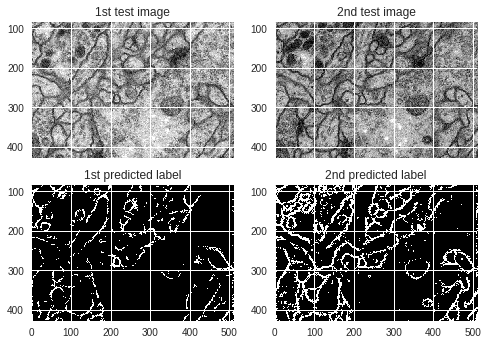

In [73]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].imshow(imgs_test[0])
ax[0,0].set_title('1st test image')
ax[1,0].imshow(pred_rf[0])
ax[1,0].set_title('1st predicted label')
ax[0,1].imshow(imgs_test[1])
ax[0,1].set_title('2nd test image')
ax[1,1].imshow(pred_rf[1])
ax[1,1].set_title('2nd predicted label')
plt.show()

(2, 512, 512)


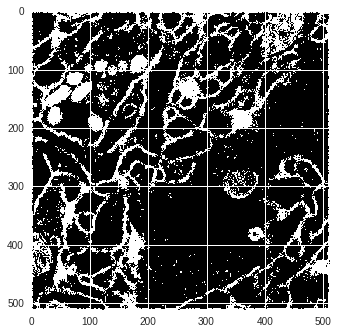

In [63]:
pred_svm = np.load('drive/data/results/SVM/SVM_img.npy')
print(pred_svm.shape)
plt.imshow(pred_svm[0])

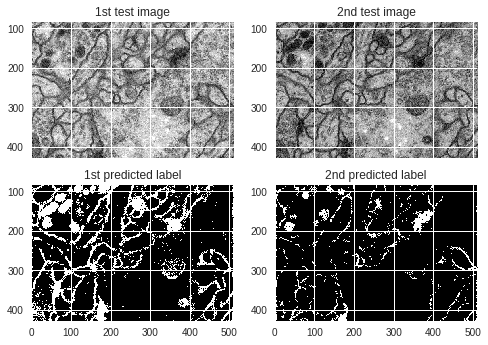

In [70]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].imshow(imgs_test[0])
ax[0,0].set_title('1st test image')
ax[1,0].imshow(pred_svm[0])
ax[1,0].set_title('1st predicted label')
ax[0,1].imshow(imgs_test[1])
ax[0,1].set_title('2nd test image')
ax[1,1].imshow(pred_svm[1])
ax[1,1].set_title('2nd predicted label')
plt.show()